# Monte Carlo Options Strategy Analysis

## 🎲 Advanced Options Analysis with Configurable Probabilities

This notebook provides a clean interface for:
- **1000+ trajectory Monte Carlo simulation**
- **Configurable probability targets** for each strategy
- **Multi-DTE analysis** (0-10 days to expiry)
- **Smart strike selection** based on ensemble forecasts

### Strategy Probability Targets:
- **Covered Call**: 95% chance of keeping stock (not assigned)
- **Long Call**: 50% chance of winning (finishing ITM)
- **Cash Secured Put**: 95% chance of avoiding assignment
- **Long Put**: 50% chance of winning (finishing ITM)

In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Import our Monte Carlo system
from models.monte_carlo_options import (
    MonteCarloTrajectoryGenerator,
    MonteCarloOptionsAnalyzer,
    StrategyConfig
)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('default')
sns.set_palette("husl")

print("🎯 Monte Carlo Options Analysis System Loaded!")
print("📊 Ready for configurable probability-based strategy optimization")

🎯 Monte Carlo Options Analysis System Loaded!
📊 Ready for configurable probability-based strategy optimization


## 📊 Step 1: Load Stock Data and Current Price

In [3]:
# Load your stock data (replace with your preferred method)
from data.loader import get_multiple_stocks

# Example: Load AAPL data
SYMBOL = 'PLTR'  # 📝 CHANGE THIS TO YOUR PREFERRED STOCK

print(f"📈 Loading {SYMBOL} data...")
stock_data = get_multiple_stocks(SYMBOL, update=False, rate_limit=2.0)

# Get current price and recent data
if SYMBOL in stock_data['Close'].columns:
    current_price = stock_data['Close'][SYMBOL].iloc[-1]
    recent_returns = stock_data['Close'][SYMBOL].pct_change().dropna().tail(100)
    
    # Calculate volatility
    daily_volatility = recent_returns.std()
    
    print(f"✅ {SYMBOL} Data Loaded:")
    print(f"   Current Price: ${current_price:.2f}")
    print(f"   Daily Volatility: {daily_volatility:.1%}")
    print(f"   Recent 20-day range: ${stock_data['Close'][SYMBOL].tail(20).min():.2f} - ${stock_data['Close'][SYMBOL].tail(20).max():.2f}")
else:
    print(f"❌ Failed to load {SYMBOL} data")
    # Fallback example
    current_price = 175.0
    daily_volatility = 0.025
    print(f"🔄 Using example data: ${current_price:.2f} with {daily_volatility:.1%} volatility")

📈 Loading PLTR data...
Loading cached data from /mnt/a61cc0e8-1b32-4574-a771-4ad77e8faab6/conda/technical_dashboard/cache/stock_data.pkl
✅ PLTR Data Loaded:
   Current Price: $154.27
   Daily Volatility: 4.3%
   Recent 20-day range: $139.12 - $158.80


## 🎲 Step 2: Configure Strategy Probabilities

**📝 EASILY MODIFY THESE VALUES TO CHANGE STRATEGY TARGETS:**

In [4]:
# 🎯 CONFIGURE YOUR STRATEGY PROBABILITIES HERE
# ================================================

strategy_config = {
    'covered_call_keep_prob': 0.95,      # 95% chance of keeping stock (conservative)
    'long_call_win_prob': 0.50,          # 50% chance of call winning (balanced)
    'csp_avoid_assignment_prob': 0.95,   # 95% chance of avoiding put assignment (conservative)
    'long_put_win_prob': 0.50            # 50% chance of put winning (balanced)
}

# Create configuration object
config = StrategyConfig.from_dict(strategy_config)

print("🎯 STRATEGY PROBABILITY CONFIGURATION:")
print("=" * 50)
for key, value in strategy_config.items():
    strategy_name = key.replace('_', ' ').title().replace(' Prob', '')
    print(f"📊 {strategy_name:<25}: {value:.1%}")

print("\n💡 TO CHANGE PROBABILITIES:")
print("   - Modify the values above and re-run this cell")
print("   - Higher values = more conservative strategies")
print("   - Lower values = more aggressive strategies")

🎯 STRATEGY PROBABILITY CONFIGURATION:
📊 Covered Call Keep        : 95.0%
📊 Long Call Win            : 50.0%
📊 Csp Avoid Assignment     : 95.0%
📊 Long Put Win             : 50.0%

💡 TO CHANGE PROBABILITIES:
   - Modify the values above and re-run this cell
   - Higher values = more conservative strategies
   - Lower values = more aggressive strategies


## 🚀 Step 3: Generate Monte Carlo Trajectories

In [5]:
# 🎲 MONTE CARLO CONFIGURATION
# ============================

N_TRAJECTORIES = 1000  # 📝 CHANGE THIS TO ADJUST SIMULATION SIZE
MAX_DAYS = 10          # Days to expiry range (0-10)
RANDOM_SEED = 42       # For reproducible results (set to None for random)

print(f"🎲 Setting up Monte Carlo simulation:")
print(f"   Trajectories: {N_TRAJECTORIES:,}")
print(f"   Days range: 0-{MAX_DAYS}")
print(f"   Current price: ${current_price:.2f}")
print(f"   Volatility: {daily_volatility:.1%}")

# Create trajectory generator
trajectory_gen = MonteCarloTrajectoryGenerator(
    n_trajectories=N_TRAJECTORIES,
    use_garch_vol=True,      # Use GARCH volatility modeling
    use_regime_switching=True,  # Use regime switching
    random_seed=RANDOM_SEED
)

# Generate trajectories
trajectories = trajectory_gen.generate_trajectories(
    current_price=current_price,
    volatility=daily_volatility,
    max_days=MAX_DAYS,
    drift=0.0005,  # Small positive drift
    regime_probs={'bull': 0.4, 'neutral': 0.4, 'bear': 0.2}
)

print(f"\n✅ Generated {trajectories.shape[0]:,} trajectories over {trajectories.shape[1]-1} days")

🎲 Setting up Monte Carlo simulation:
   Trajectories: 1,000
   Days range: 0-10
   Current price: $154.27
   Volatility: 4.3%
🎲 Generating 1000 Monte Carlo trajectories for 10 days
✅ Generated trajectories: (1000, 11)
   Price range at day 10: $101.54 - $235.19
   Mean final price: $154.54

✅ Generated 1,000 trajectories over 10 days


## 📈 Step 4: Visualize Trajectories

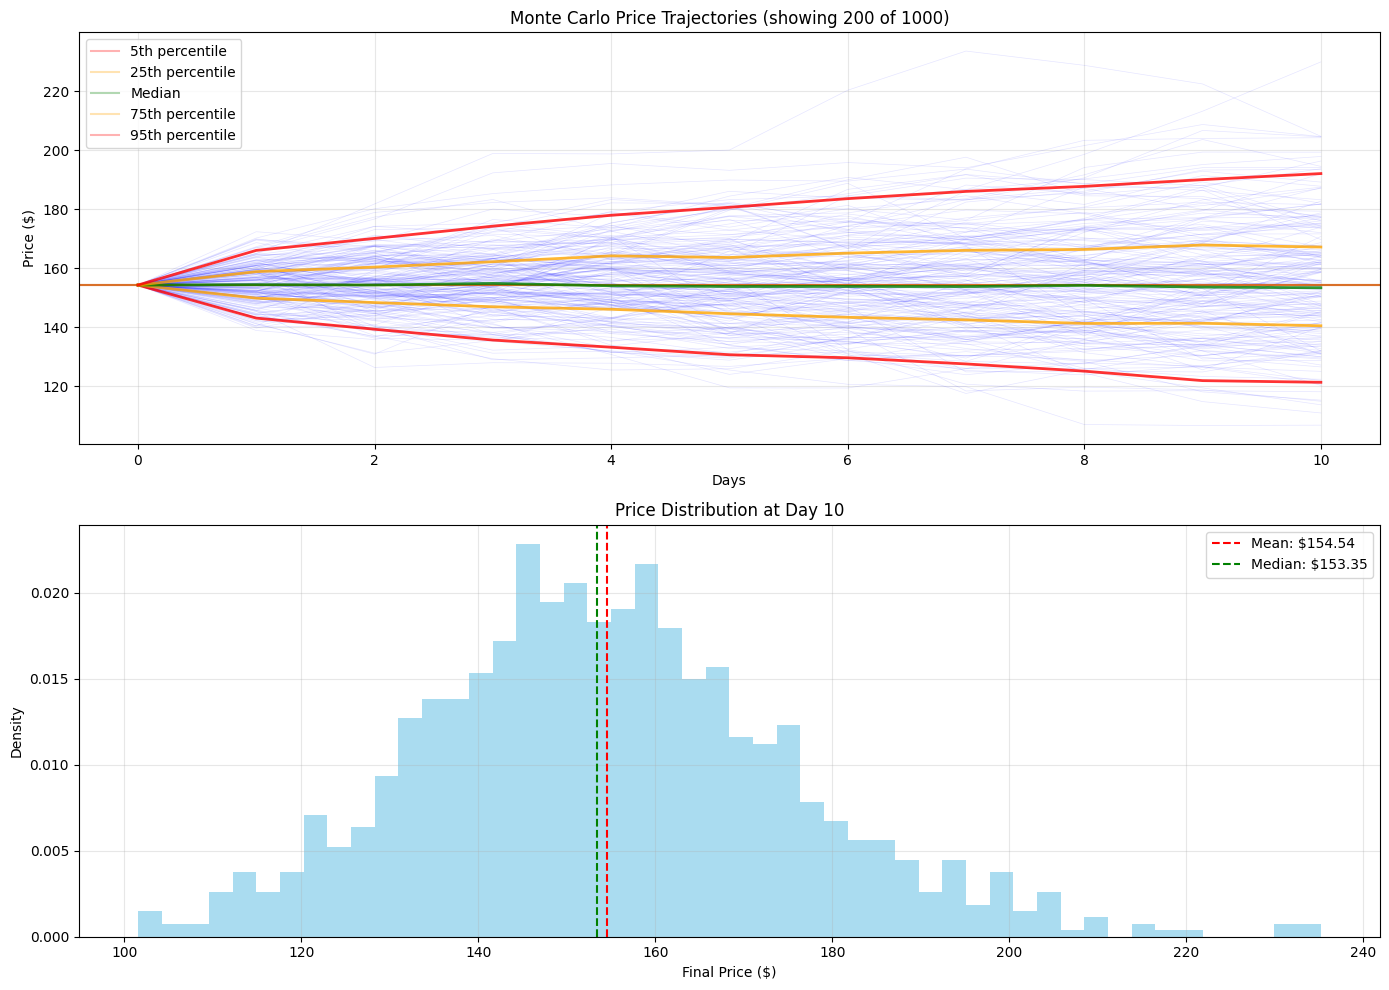

In [6]:
# Plot the Monte Carlo trajectories
trajectory_gen.plot_trajectories(n_show=200, show_percentiles=True, figsize=(14, 10))

## 🎯 Step 5: Find Optimal Strikes for All Strategies

This will find the optimal strike prices that meet your probability targets:

In [ ]:
# Create options analyzer
options_analyzer = MonteCarloOptionsAnalyzer(
    trajectory_generator=trajectory_gen,
    strategy_config=config
)

# Find optimal strikes for all strategies across all DTEs
print(f"🔍 Finding optimal strikes based on your probability targets...")
print(f"📊 Analyzing {current_price:.2f} stock price across 0-{MAX_DAYS} DTE")

results = options_analyzer.find_optimal_strikes(
    current_price=current_price,
    max_dte=MAX_DAYS,
    risk_free_rate=0.05
)

print(f"\n✅ Analysis complete! Found optimal strikes for all strategies.")

## 📊 Step 6: View Complete Results Table

In [ ]:
# Get comprehensive results table
summary_table = options_analyzer.get_strategy_summary_table()

print("📊 COMPLETE MONTE CARLO OPTIONS ANALYSIS RESULTS")
print("=" * 80)
print(f"🎲 Based on {N_TRAJECTORIES:,} trajectories")
print(f"💰 Current Price: ${current_price:.2f}")
print(f"📈 Volatility: {daily_volatility:.1%}")
print()

# Display the full table
display(summary_table)

# Show key insights
print("\n🔍 KEY INSIGHTS:")
print("-" * 20)

# Best strategies by expected P&L
numeric_pnl = summary_table['Expected_PnL'].str.replace('$', '').str.replace(',', '').astype(float)
best_strategy_idx = numeric_pnl.idxmax()
best_strategy = summary_table.iloc[best_strategy_idx]

print(f"💎 Best Expected P&L: {best_strategy['Strategy']} at {best_strategy['DTE']}DTE")
print(f"   Strike: {best_strategy['Strike']}, Expected P&L: {best_strategy['Expected_PnL']}")

# Most accurate probability matching
prob_diff = summary_table['Prob_Diff'].str.replace('%', '').astype(float)
most_accurate_idx = prob_diff.idxmin()
most_accurate = summary_table.iloc[most_accurate_idx]

print(f"🎯 Most Accurate Probability Match: {most_accurate['Strategy']} at {most_accurate['DTE']}DTE")
print(f"   Target: {most_accurate['Target_Prob']}, Actual: {most_accurate['Success_Prob']}, Diff: {most_accurate['Prob_Diff']}")

## 📈 Step 7: Visualize Strategy Analysis

In [ ]:
# Create comprehensive strategy visualization
options_analyzer.plot_strategy_analysis(figsize=(16, 12))

## 🎯 Step 8: Strategy-Specific Analysis

Let's examine each strategy in detail:

In [ ]:
# Analyze each strategy separately
strategies = ['covered_call', 'long_call', 'cash_secured_put', 'long_put']
strategy_names = ['Covered Call', 'Long Call', 'Cash Secured Put', 'Long Put']

for strategy, name in zip(strategies, strategy_names):
    if strategy in results:
        print(f"\n📊 {name.upper()} ANALYSIS")
        print("=" * 50)
        
        strategy_data = results[strategy]
        
        # Find best DTE by expected P&L
        best_dte = max(strategy_data.keys(), key=lambda d: strategy_data[d].expected_pnl)
        best_result = strategy_data[best_dte]
        
        print(f"🏆 BEST DTE: {best_dte} days")
        print(f"   Strike Price: ${best_result.strike_price:.2f}")
        print(f"   Success Probability: {best_result.success_probability:.1%} (target: {best_result.target_probability:.1%})")
        print(f"   Expected P&L: ${best_result.expected_pnl:.2f}")
        print(f"   Premium Estimate: ${best_result.premium_estimate:.2f}")
        
        print(f"\n📈 ALL DTEs:")
        for dte in sorted(strategy_data.keys()):
            result = strategy_data[dte]
            prob_match = "✅" if abs(result.success_probability - result.target_probability) < 0.05 else "⚠️"
            print(f"   {dte}DTE: ${result.strike_price:.2f} | {result.success_probability:.1%} | ${result.expected_pnl:.2f} {prob_match}")

## 🔄 Step 9: Reconfigure Probabilities (Optional)

Want to try different probability targets? Run this cell with new values:

In [ ]:
# 🎯 EXPERIMENT WITH DIFFERENT PROBABILITIES
# ===========================================

# Example: More aggressive configuration
aggressive_config = {
    'covered_call_keep_prob': 0.80,      # 80% chance (more aggressive)
    'long_call_win_prob': 0.60,          # 60% chance (higher confidence)
    'csp_avoid_assignment_prob': 0.85,   # 85% chance (less conservative)
    'long_put_win_prob': 0.60            # 60% chance (higher confidence)
}

# Update configuration
options_analyzer.update_config(aggressive_config)

# Re-run analysis with new probabilities
print("🔄 Re-analyzing with new probability targets...")
new_results = options_analyzer.find_optimal_strikes(
    current_price=current_price,
    max_dte=MAX_DAYS,
    risk_free_rate=0.05
)

# Show new results
new_summary = options_analyzer.get_strategy_summary_table()
print("\n📊 RESULTS WITH AGGRESSIVE PROBABILITIES:")
display(new_summary.head(10))

print("\n💡 Compare these results to the previous ones to see the impact of probability changes!")

## 🛠️ Step 10: Advanced Trajectory Analysis

Dive deeper into the Monte Carlo simulation:

In [ ]:
# Analyze trajectory statistics at different days
print("📊 TRAJECTORY STATISTICS BY DAY")
print("=" * 60)

stats_data = []
for day in range(0, MAX_DAYS + 1):
    stats = trajectory_gen.get_price_statistics(day)
    stats_data.append({
        'Day': day,
        'Mean': f"${stats['mean']:.2f}",
        'Median': f"${stats['median']:.2f}",
        'Std': f"${stats['std']:.2f}",
        '5th_Pct': f"${stats['q05']:.2f}",
        '95th_Pct': f"${stats['q95']:.2f}",
        'Range': f"${stats['max'] - stats['min']:.2f}",
        'Skewness': f"{stats['skewness']:.3f}"
    })

stats_df = pd.DataFrame(stats_data)
display(stats_df)

print(f"\n🎲 Based on {N_TRAJECTORIES:,} Monte Carlo trajectories")
print(f"📊 Showing price evolution over {MAX_DAYS} days")
print(f"💡 Use this data to understand price distribution at each DTE")

## 💾 Step 11: Export Results

Save your analysis for later use:

In [ ]:
# Export results to CSV
timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
filename = f'monte_carlo_options_analysis_{SYMBOL}_{timestamp}.csv'

# Get final summary table
final_summary = options_analyzer.get_strategy_summary_table()

# Add metadata
metadata_row = pd.DataFrame([{
    'Strategy': 'METADATA',
    'DTE': f'Symbol: {SYMBOL}',
    'Strike': f'Current: ${current_price:.2f}',
    'Success_Prob': f'Trajectories: {N_TRAJECTORIES}',
    'Target_Prob': f'Volatility: {daily_volatility:.1%}',
    'Prob_Diff': f'Days: 0-{MAX_DAYS}',
    'Expected_PnL': f'Generated: {timestamp}',
    'Max_Profit': '',
    'Max_Loss': '',
    'Premium': ''
}])

# Combine and save
export_data = pd.concat([metadata_row, final_summary], ignore_index=True)
export_data.to_csv(filename, index=False)

print(f"💾 Results exported to: {filename}")
print(f"📊 {len(final_summary)} strategy results saved")
print(f"🎯 Analysis for {SYMBOL} at ${current_price:.2f} with {N_TRAJECTORIES:,} trajectories")

## 🎉 Analysis Complete!

### 🔧 **Easy Reconfiguration Guide:**

1. **Change Probabilities**: Modify Step 2 values and re-run
2. **Change Stock**: Update `SYMBOL` in Step 1
3. **More Trajectories**: Increase `N_TRAJECTORIES` in Step 3
4. **Longer Analysis**: Increase `MAX_DAYS` in Step 3
5. **Different Volatility**: Modify `daily_volatility` manually

### 📊 **What You Get:**
- Optimal strike prices for each strategy at each DTE
- Success probabilities matching your targets
- Expected P&L calculations
- Premium estimates
- Visual analysis of all strategies

### 🎯 **Key Benefits:**
- **Ensemble-based**: Uses 1000+ price trajectories
- **Configurable**: Easy probability target adjustment
- **Multi-DTE**: Analysis across 0-10 days to expiry
- **Risk-aware**: Proper probability-based strike selection

**🚀 Your Monte Carlo options analysis is complete!**